In [12]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import Conv2D,Conv2DTranspose,BatchNormalization,LeakyReLU,Input,concatenate,Dropout,UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from keras.models import Model

In [13]:
path_gray = 'dataset/gray/'
path_color = 'dataset/color/'

In [14]:
# sortiranje dobijenih podataka
def sort_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

In [15]:
def create_image_array(file_path,  gray = False, image_size = 180):

    image_array = []
    files = os.listdir(file_path)
    files = sort_alphanumeric(files)
    for i in tqdm(files): 
        image = cv2.imread(file_path +'/'+ i,1)

        if not gray:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        image = cv2.resize(image, (image_size, image_size))
        image = image.astype("float32") / 255.0

        image_array.append(img_to_array(image))

    return image_array


In [16]:
color_img = create_image_array('dataset/color')

100%|██████████| 7129/7129 [00:21<00:00, 328.22it/s]


In [17]:
gray_img = create_image_array('dataset/gray', True)

100%|██████████| 7129/7129 [00:27<00:00, 258.85it/s]


In [18]:
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

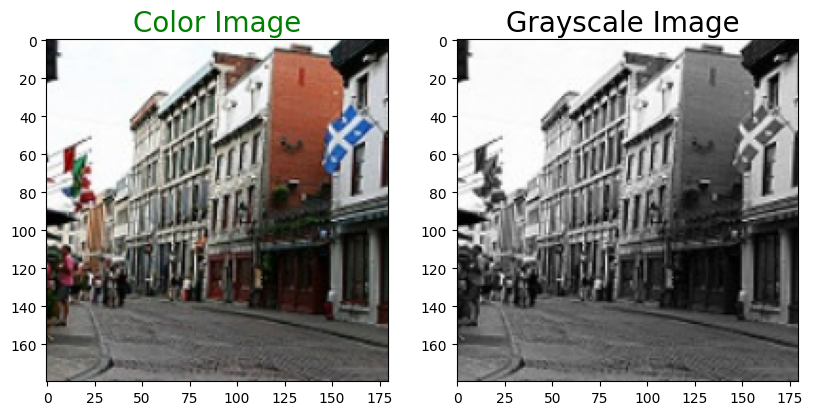

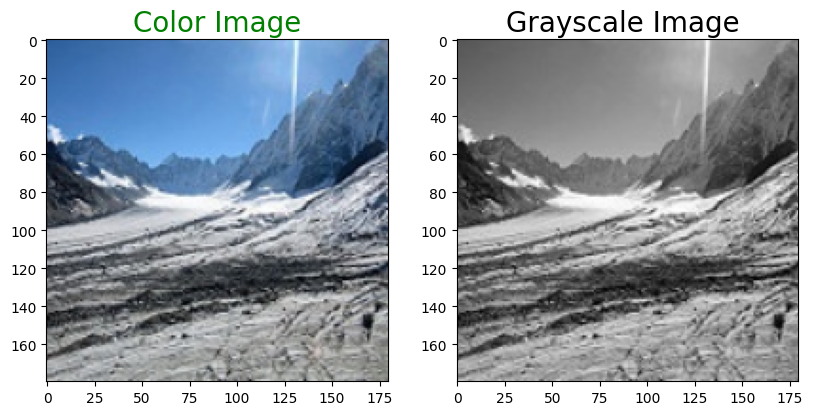

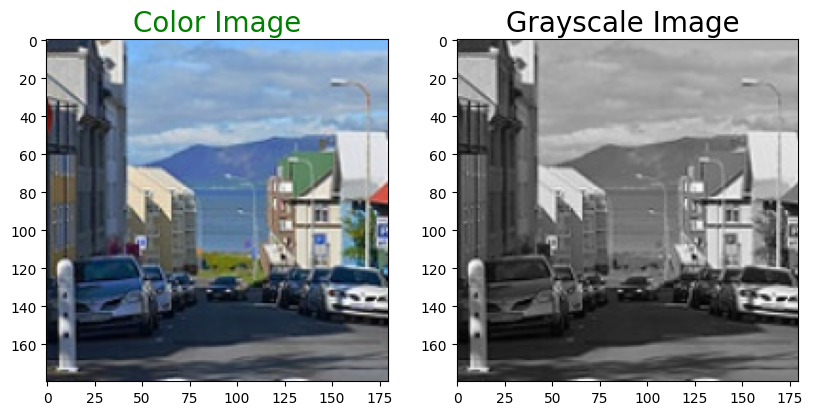

In [19]:
for i in range(3,6):
     plot_images(color_img[i],gray_img[i])

In [94]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, color_path, gray_path, batch_size, image_size, image_names, shuffle=True):
        'Initialization'
        self.color_path = color_path
        self.grayscale_path = gray_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_names = image_names
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_names))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_names) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_color_images = []
        batch_gray_images = []

        for i in indexes:
            rgb_image = cv2.imread(os.path.join(self.color_path, self.image_names[i]))
            rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
            rgb_image = cv2.resize(rgb_image, (self.image_size, self.image_size))
            rgb_image = rgb_image.astype("float32") / 255.0
            batch_color_images.append(img_to_array(rgb_image))

            grayscale_image = cv2.imread(os.path.join(self.grayscale_path, self.image_names[i]), cv2.IMREAD_GRAYSCALE)
            grayscale_image = cv2.resize(grayscale_image, (self.image_size, self.image_size))
            grayscale_image = grayscale_image.astype("float32") / 255.0
            grayscale_image = np.expand_dims(grayscale_image, axis=-1)
            batch_gray_images.append(grayscale_image)

        return np.array(batch_gray_images), np.array(batch_color_images)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_names))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [95]:
# Podela podataka na trening i test skup podataka i pravljenje generatora podataka.
image_names = sort_alphanumeric(os.listdir(path_color))
TRAINING_SIZE = int(len(image_names) * 0.8)
train_image_names = image_names[:TRAINING_SIZE]
test_image_names = image_names[TRAINING_SIZE:]

In [105]:
train_generator = DataGenerator(path_color,path_gray,32,160,train_image_names)
test_generator = DataGenerator(path_color,path_gray,8,160,test_image_names)

In [98]:
def up(filters, kernel_size, dropout=False):
    upsample = Sequential()
    upsample.add(Conv2DTranspose(filters, kernel_size, padding='same', strides=2))
    if dropout:
        upsample.add(Dropout(0.2))
    upsample.add(LeakyReLU())
    return upsample

In [100]:
def down(filters, kernel_size, apply_batch_normalization=True):
    downsample = Sequential()
    downsample.add(Conv2D(filters, kernel_size, padding='same', strides=2))
    if apply_batch_normalization:
        downsample.add(BatchNormalization())
    downsample.add(LeakyReLU())
    return downsample

In [109]:
def build_autoencoder():
    inputs = Input(shape= [160,160,1])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = concatenate([u5,inputs])
    output = Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [110]:
# Build and compile the model
autoencoder = build_autoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['accuracy'])

# Check the model summary to see the tensor shapes
autoencoder.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 160, 160, 1)]        0         []                            
                                                                                                  
 sequential_74 (Sequential)  (None, 80, 80, 128)          1280      ['input_15[0][0]']            
                                                                                                  
 sequential_75 (Sequential)  (None, 40, 40, 128)          147584    ['sequential_74[0][0]']       
                                                                                                  
 sequential_76 (Sequential)  (None, 20, 20, 256)          296192    ['sequential_75[0][0]']       
                                                                                           

In [117]:
autoencoder.fit(train_generator, validation_data=test_generator, epochs=10)

Epoch 1/10
178/178 [==============================] - 896s 5s/step - loss: 0.0461 - accuracy: 0.5256 - val_loss: 0.0510 - val_accuracy: 0.5297
Epoch 2/10
178/178 [==============================] - 862s 5s/step - loss: 0.0458 - accuracy: 0.5293 - val_loss: 0.0472 - val_accuracy: 0.5059
Epoch 3/10
178/178 [==============================] - 880s 5s/step - loss: 0.0449 - accuracy: 0.5450 - val_loss: 0.0471 - val_accuracy: 0.5342
Epoch 4/10
178/178 [==============================] - 880s 5s/step - loss: 0.0448 - accuracy: 0.5480 - val_loss: 0.0500 - val_accuracy: 0.4523
Epoch 5/10
178/178 [==============================] - 896s 5s/step - loss: 0.0443 - accuracy: 0.5501 - val_loss: 0.0470 - val_accuracy: 0.4610
Epoch 6/10
178/178 [==============================] - 899s 5s/step - loss: 0.0441 - accuracy: 0.5534 - val_loss: 0.0459 - val_accuracy: 0.5491
Epoch 7/10
178/178 [==============================] - 894s 5s/step - loss: 0.0435 - accuracy: 0.5644 - val_loss: 0.0487 - val_accuracy: 0.5165

In [118]:
autoencoder.evaluate(test_generator)

178/178 [==============================] - 79s 442ms/step - loss: 0.0543 - accuracy: 0.4236


[0.05431590601801872, 0.42359164357185364]

In [135]:
def generate_examples(model, test_generator, num_examples=5):
    count = 0
    for batch in test_generator:
        if count >= num_examples:
            break
        grayscale_images, rgb_images = batch
        predictions = model.predict(grayscale_images)
        for i in range(len(grayscale_images)):
            input_image = grayscale_images[i]
            target_image = rgb_images[i]
            predicted_image = predictions[i]
            display_list = [input_image, target_image, predicted_image]
            title = ["Input (Grayscale)", "Ground Truth (Color)", "Predicted (Color)"]
            plt.figure(figsize=(15, 5))
            for j in range(3):
                plt.subplot(1, 3, j + 1)
                plt.title(title[j])
                if j == 0:  # Grayscale image
                    plt.imshow(display_list[j], cmap='gray')
                else:
                    plt.imshow(display_list[j])
                plt.axis("off")
            plt.show()
            count += 1
            if count >= num_examples:
                break

In [133]:
gray_images, color_images = next(iter(test_generator))

# Predict the colorized images
predicted_color_images = autoencoder.predict(gray_images)

# # Denormalize images for visualization
# gray_images = (gray_images * 255).astype("uint8")
# color_images = (color_images * 255).astype("uint8")
predicted_color_images = (predicted_color_images * 255).astype("uint8")

1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 1s 748ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28295287..1.0313119].


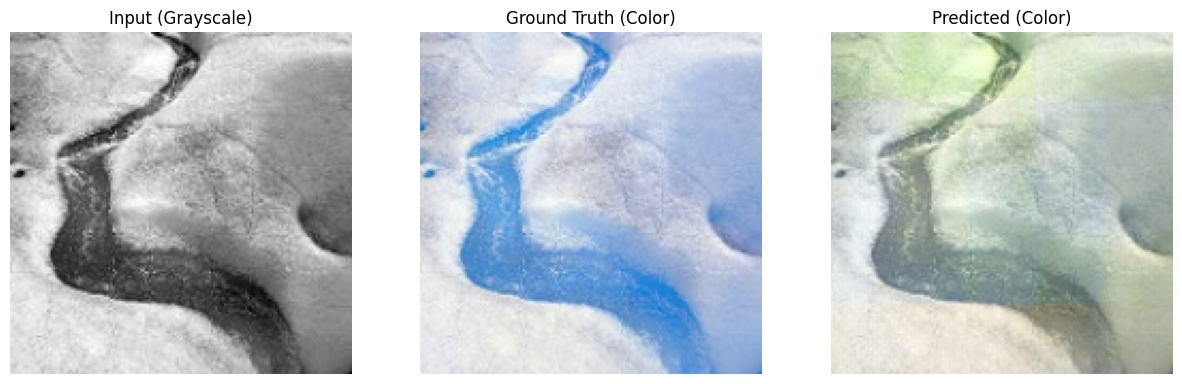

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024718143..1.0569284].


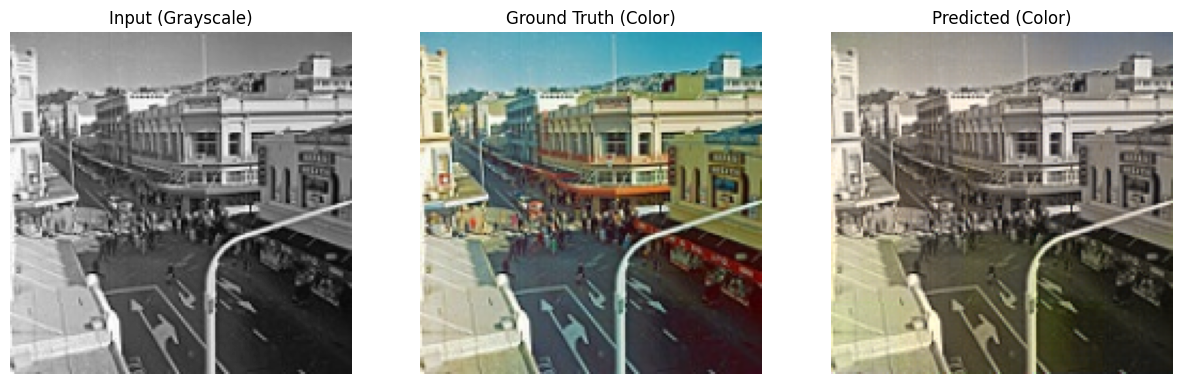

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.021452222..1.026557].


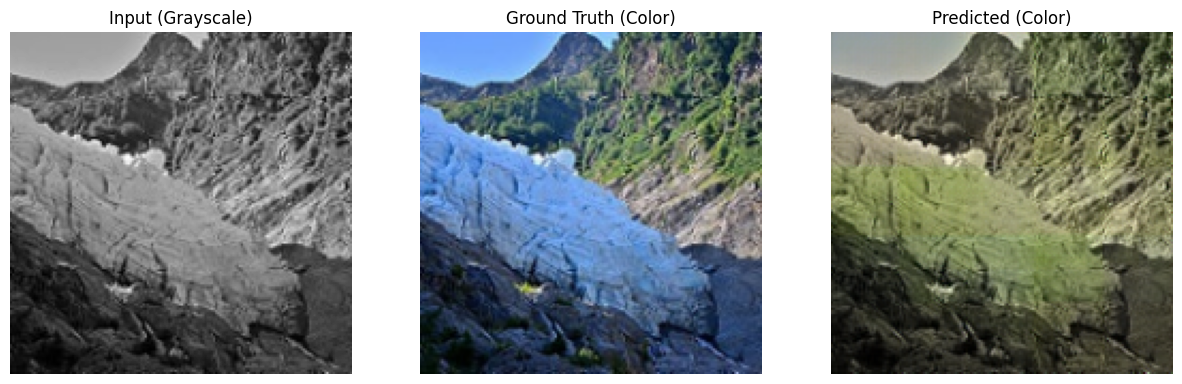

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.051100574..1.0471028].


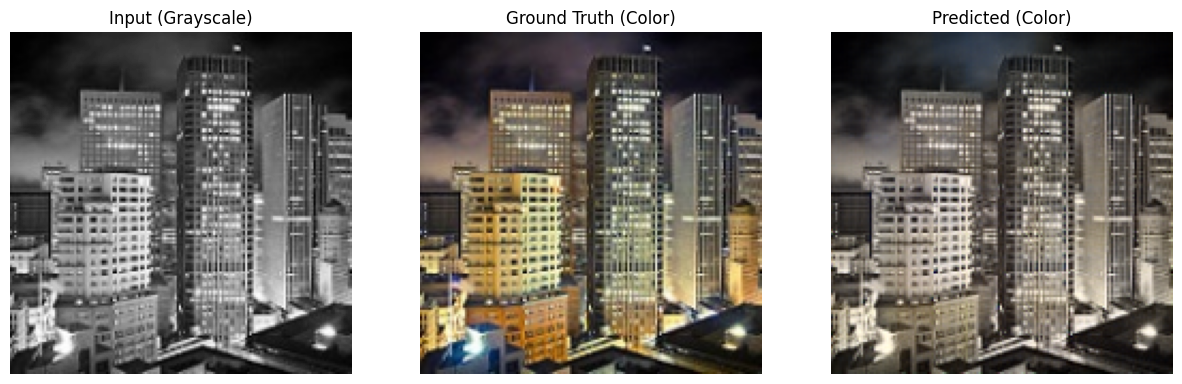

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06439582..1.0248616].


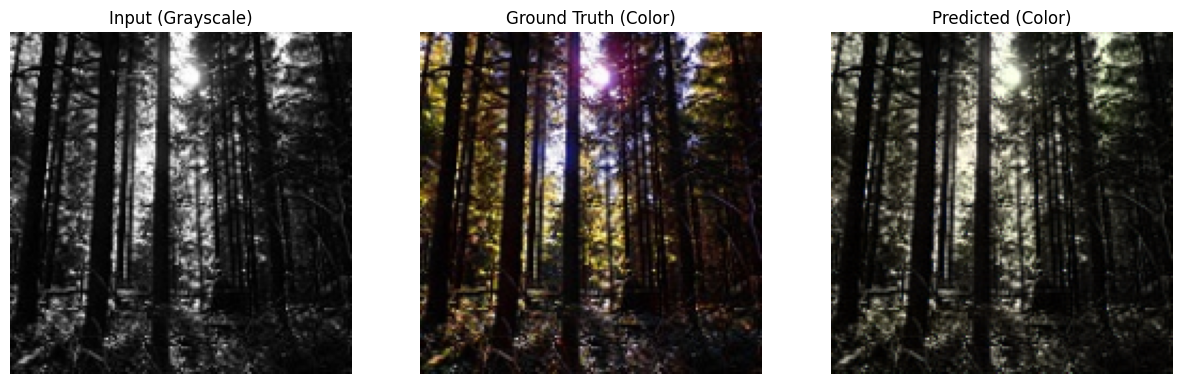

In [136]:
# Prikaz rezultata.
generate_examples(autoencoder, test_generator, num_examples=5)